# Transer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main beenfits:
1. Can leverage an existing neural network architecture proven to work on problems similiar to our own.
2. Can leverage a working neural network architecture which ha already learned patterns on similiar data to our own, then we cat adapt those patterns to our own data

## Downloading and becoming one with the data

In [1]:
# Get data
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2024-03-29 03:08:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.207, 173.194.195.207, 173.194.196.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   119MB/s    in 1.4s    

2024-03-29 03:08:22 (119 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
# How many images in each folder?
import os

# Walk through  10 percent data directory
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 10 directori

## Creating data loaders

We'll use the `ImageDataGenerator` class to load in our images in batches.

In [3]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

print("Testing images:")
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE
)

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks are:

* Tracking experiments with the TensorBoard callback
* Model checkpoing with the ModelCheckpoint callback
* Stopping a model from training (before it overfits) with EarlyStopping callback

In [4]:
# Create TensorBoard callback
import datetime
import tensorflow as tf

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard files to {log_dir}")
  return tensorboard_callback

## Creating models using Tensorflow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similiar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on: https://tfhub.dev/

In [5]:
# Let's comparw the following two models
resnet_url = "https://www.kaggle.com/models/google/resnet-v2/frameworks/TensorFlow2/variations/50-feature-vector/versions/2"

efficientnet = "https://www.kaggle.com/models/google/efficientnet-v2/frameworks/TensorFlow2/variations/imagenet1k-b0-feature-vector/versions/2"

In [6]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
# Let's make a create_model()
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target_class, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMG_SHAPE+(3,))

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Featurre Extraction model

In [8]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [10]:
# Compile a model
resnet_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [13]:
# Fit the model
resnet_history = resnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback('tensorflow_hub', 'resnet50V2')]
)

Saving TensorBoard files to tensorflow_hub/resnet50V2/20240329-031137
Epoch 1/5
24/24 [==============================] - 10s 423ms/step - loss: 0.1674 - accuracy: 0.9893 - val_loss: 0.6253 - val_accuracy: 0.7888
Epoch 2/5
24/24 [==============================] - 10s 428ms/step - loss: 0.1476 - accuracy: 0.9907 - val_loss: 0.6291 - val_accuracy: 0.7912
Epoch 3/5
24/24 [==============================] - 11s 454ms/step - loss: 0.1298 - accuracy: 0.9933 - val_loss: 0.6238 - val_accuracy: 0.7928
Epoch 4/5
24/24 [==============================] - 10s 443ms/step - loss: 0.1138 - accuracy: 0.9947 - val_loss: 0.6261 - val_accuracy: 0.7860
Epoch 5/5
24/24 [==============================] - 10s 439ms/step - loss: 0.1027 - accuracy: 0.9933 - val_loss: 0.6188 - val_accuracy: 0.7972


Wow!

That. Is. Incredible. our tranfer learning feature extraction model outperformed ALL of the previous models we built by hand.. and in a quicker training time AND with only 10% if the training examples.

In [17]:
resnet_history.history

{'loss': [0.16738168895244598,
  0.1476449966430664,
  0.12977030873298645,
  0.11379388719797134,
  0.10272539407014847],
 'accuracy': [0.9893333315849304,
  0.9906666874885559,
  0.9933333396911621,
  0.9946666955947876,
  0.9933333396911621],
 'val_loss': [0.6253353357315063,
  0.6291355490684509,
  0.6238194108009338,
  0.6261448860168457,
  0.6188233494758606],
 'val_accuracy': [0.7888000011444092,
  0.7911999821662903,
  0.7928000092506409,
  0.7860000133514404,
  0.7972000241279602]}

In [36]:
# Let's recreate plot_loss_curves func
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

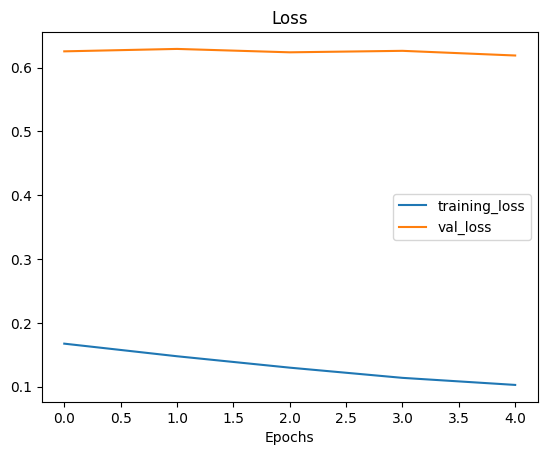

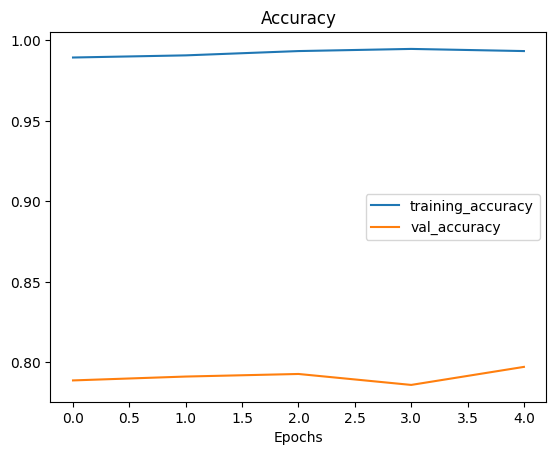

In [37]:
plot_loss_curves(resnet_history)

### Creating and testing Efficientnet TensorFlow Hub Featurre Extraction model

In [38]:
efficientnet_model = create_model(efficientnet,
                                  num_classes=train_data_10_percent.num_classes)

In [39]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              5919312   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


In [40]:
efficientnet_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [42]:
# Fit the model
efficientnet_history = efficientnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientne1KB0")]
)

Saving TensorBoard files to tensorflow_hub/efficientne1KB0/20240329-034944
Epoch 1/5
24/24 [==============================] - 22s 558ms/step - loss: 1.8679 - accuracy: 0.4200 - val_loss: 1.4474 - val_accuracy: 0.6460
Epoch 2/5
24/24 [==============================] - 10s 423ms/step - loss: 1.2576 - accuracy: 0.6733 - val_loss: 1.0889 - val_accuracy: 0.7136
Epoch 3/5
24/24 [==============================] - 10s 443ms/step - loss: 0.9847 - accuracy: 0.7533 - val_loss: 0.9282 - val_accuracy: 0.7452
Epoch 4/5
24/24 [==============================] - 12s 531ms/step - loss: 0.8303 - accuracy: 0.8000 - val_loss: 0.8442 - val_accuracy: 0.7660
Epoch 5/5
24/24 [==============================] - 9s 396ms/step - loss: 0.7263 - accuracy: 0.8293 - val_loss: 0.7856 - val_accuracy: 0.7732


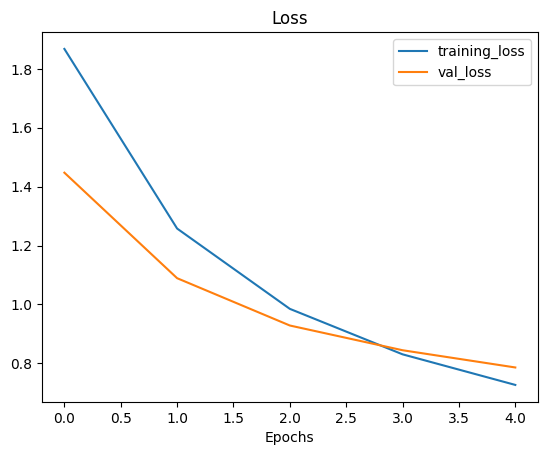

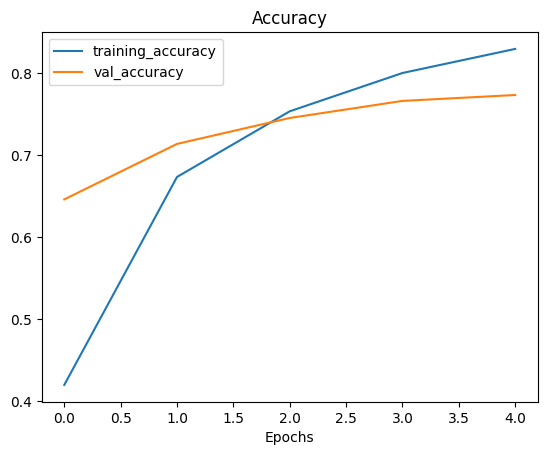

In [44]:
plot_loss_curves(efficientnet_history)

## Different types of transfer learning

* "As is" transfer learning - using an exisiting model with no changes what so ever.
* "Feature extraction" transfer learning - use the prelearned patterns of an existing model and adjust the output layer for your own problem.
* "Fine-tuning" transfer learning - use the prelearned patterns of an existing model and "fine-tune" many or all of the underlying layers.

## Comparing our models using TensorBoard

> **Note:** when you upload things to TensorBoard.dev, your experiments are public!!

In [48]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ --name "EfficientNetB0 vs. ResNet50V2 1f22" --description "Comparing two different TF Hub feature extraction model architectures using 10% if the train dataset" --one_shot

2024-03-29 04:27:19.281133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 04:27:19.281191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 04:27:19.282518: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 04:27:20.285151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

In [49]:
# Check out what TensorBoard experiments you have
!tensorboard dev list

2024-03-29 04:33:28.570884: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 04:33:28.570942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 04:33:28.572560: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 04:33:29.785659: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard.dev Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to

In [50]:
# Delete an experiment
# !tensorboard dev delete --experiment_id [ID]